In [1]:
# using IJulia
# # This creates a new kernel option in your Jupyter 'New' menu
# IJulia.installkernel("Julia (4 threads)", env=Dict("JULIA_NUM_THREADS" => "4"))

In [2]:
using PyCall
using Printf
using Dates
using LinearAlgebra

# Force BLAS to use 1 thread to avoid contention with Julia threads
BLAS.set_num_threads(1)

# 1. Load the Updated PolyhedraTree module
include("../geobin_jl/geobin.jl")
using .Geobin

# 2. Setup Python Environment
sys = pyimport("sys")
pushfirst!(PyVector(sys."path"), "../")

# Import python libraries
torch = pyimport("torch")
src_exp = pyimport("src_experiment")

# Helper: Convert PyTorch state to Julia Array immediately
# CRITICAL: We convert to Array{Float64} to detach from Python memory management
function convert_torch_state(py_state)
    jl_dict = Dict{String, Any}()
    for (k, v) in py_state
        if pyisinstance(v, torch.Tensor)
            # .copy() ensures we own the data in Julia
            jl_dict[String(k)] = convert(Array{Float64}, v.detach().cpu().numpy())
        else
            jl_dict[String(k)] = v
        end
    end
    return jl_dict
end

function main()
    # 1. Get Path (using as_posix as requested)
    base_path_py = src_exp.get_test_data().absolute()
    base_path = base_path_py.as_posix()
    
    println("Current Working Directory: $(pwd())")
    println("Base Data Path resolved to: $base_path")

    epochs = [0, 10, 20, 30, 40]
    trees = Dict{Int, Any}()
    
    tot_start = time()
    
    for epoch in epochs
        state_dict_path = joinpath(base_path, "state_dicts", "epoch$(epoch).pth")
        
        if !isfile(state_dict_path)
            println("\n!!! ERROR: File not found: $state_dict_path")
            continue 
        end
        
        println("\nLoading: $state_dict_path")
        
        # --- LOAD & DETACH ---
        # We load inside a 'let' block and force GC to ensure NO Python objects 
        # exist when we enter the multi-threaded construction phase.
        state = let
            raw_state = torch.load(state_dict_path, map_location="cpu")
            convert_torch_state(raw_state)
        end
        
        # Force Garbage Collection to clean up PyCall objects
        GC.gc() 
        
        println("--- Epoch $epoch ---")
        start_t = time()
        
        # Initialize Tree
        tree = Geobin.Tree(state)
        
        # Run Robust Construction (CSG / Incremental Splitting)
        Geobin.construct_tree!(tree, verbose=true)
        
        trees[epoch] = tree
        
        end_t = time()
        @printf("Duration: %.2f s\n", end_t - start_t)
        
        # Optional: Print stats
        leaves = Geobin.get_regions_at_layer(tree, tree.L)
        println("  Found $(length(leaves)) final regions.")
    end
    
    tot_end = time()
    @printf("Total duration: %.2f s\n", tot_end - tot_start)
    
    return trees
end

# Check threads
if Threads.nthreads() == 1
    println("Warning: Running on 1 thread. Run with 'julia --threads auto main.jl'")
end
print(Threads.nthreads())
trees = main()

22Current Working Directory: /home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks
Base Data Path resolved to: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing

Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch0.pth
--- Epoch 0 ---
Layer 1: Processing 1 regions...
Layer 2: Processing 7 regions...
Layer 3: Processing 21 regions...
Layer 4: Processing 59 regions...
Duration: 6.16 s
  Found 82 final regions.

Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch10.pth
--- Epoch 10 ---
Layer 1: Processing 1 regions...
Layer 2: Processing 7 regions...
Layer 3: Processing 15 regions...
Layer 4: Processing 43 regions...
Duration: 0.42 s
  Found 63 final regions.

Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch20.pth
--- Epoch 20 ---
Layer 1: Processing 1 regions...
Layer 2: Processing 7 reg

Dict{Int64, Any} with 5 entries:
  0  => Tree(depth=4, input_dim=2, total_nodes=...)
  20 => Tree(depth=4, input_dim=2, total_nodes=...)
  10 => Tree(depth=4, input_dim=2, total_nodes=...)
  30 => Tree(depth=4, input_dim=2, total_nodes=...)
  40 => Tree(depth=4, input_dim=2, total_nodes=...)

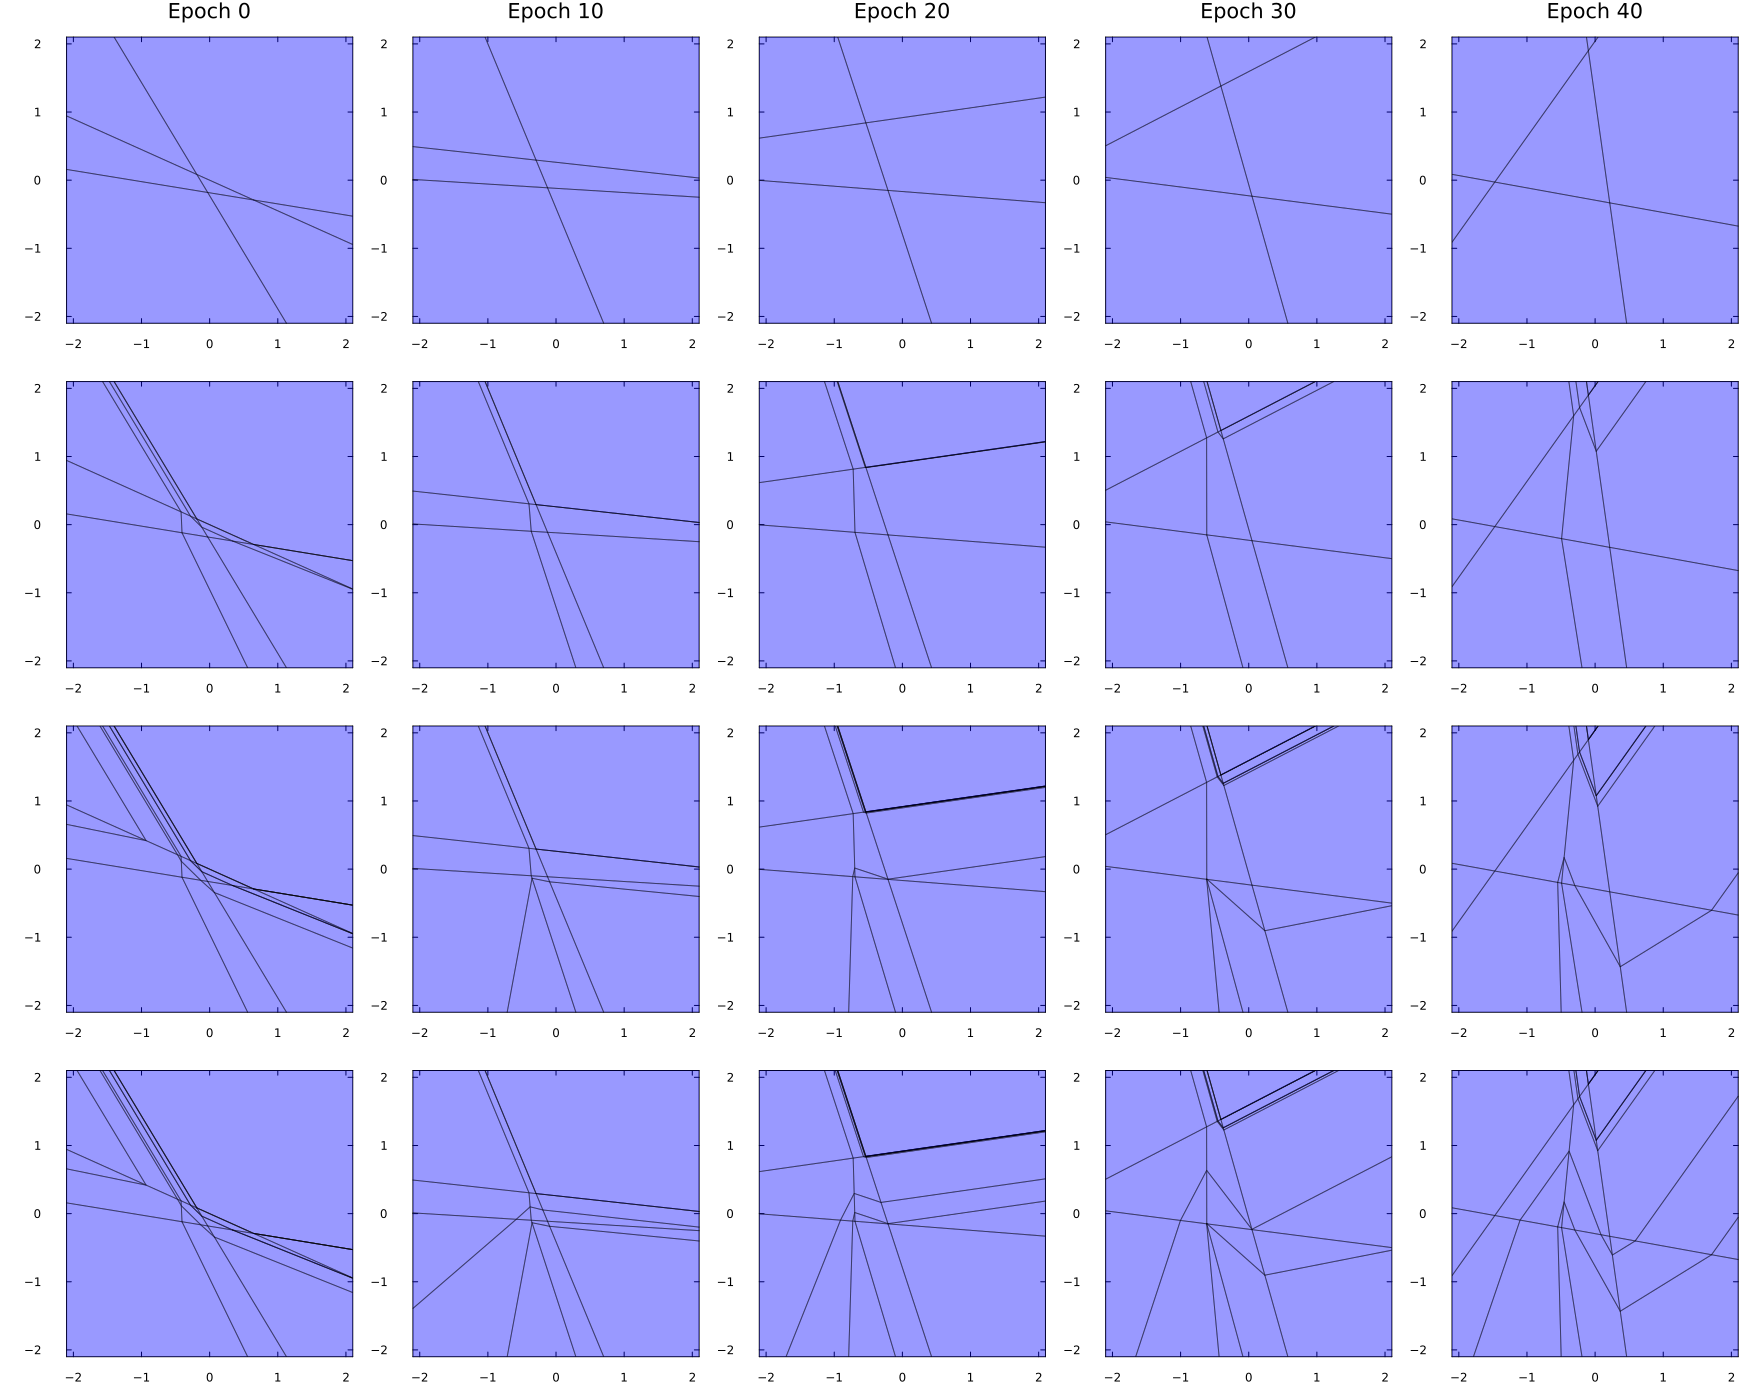

"/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/grid_visualization.png"

In [3]:
using Polyhedra
using CDDLib      # The backend solver (C-library)
using Plots
using Colors
using LinearAlgebra

# 1. Helper to create a bounded polyhedron from a Region
function get_bounded_polyhedron(region; bound=100)
    # Get the inequalities from your struct: Dlw * x <= glw
    # We explicitly copy them to ensure we don't mutate the tree
    A, b = Geobin.get_path_inequalities(region)
    
    # Dimensions
    dim = size(A, 2)
    
    # Create Bounding Box Constraints: -bound <= x <= bound
    # This is equivalent to:  I*x <= bound  AND -I*x <= bound
    I_mat = Matrix{Float64}(I, dim, dim)
    
    A_box = vcat(I_mat, -I_mat)      # Stack identity and negative identity
    b_box = fill(bound, 2 * dim)     # Vector of [bound, bound, ...]
    
    # Combine Region constraints with Box constraints
    A_full = vcat(A, A_box)
    b_full = vcat(b, b_box)
    
    # Create the Polyhedron using CDDLib
    # H-representation: {x | Ax <= b}
    h = hrep(A_full, b_full)
    poly = polyhedron(h, CDDLib.Library())
    
    # Compute vertices (V-representation) to check if empty/valid
    # removevredundancy! triggers the computation of vertices
    try
        removevredundancy!(poly)
        if isempty(poly)
            return nothing
        end
        return poly
    catch e
        return nothing
    end
end

# 2. Main Plotting Function
function plot_epoch_layer_grid(trees; bound=10)
    epochs = sort(collect(keys(trees)))
    num_epochs = length(epochs)
    
    # Assume all trees have same depth
    num_layers = trees[epochs[1]].L
    
    # Setup the plot layout (Grid: Layers x Epochs)
    # layout = @layout [grid(num_layers, num_epochs)]
    
    # Initialize a large plot object with subplots
    p = plot(layout = (num_layers, num_epochs), 
             size = (num_epochs * 350, num_layers * 350),
             legend = false,
             framestyle = :box)

    for (col, epoch) in enumerate(epochs)
        tree = trees[epoch]
        
        for layer in 1:num_layers
            # Calculate subplot index (linear indexing in Julia Plots)
            # Row `layer`, Column `col`
            subplot_idx = (layer - 1) * num_epochs + col
            
            # Formatting (Titles and Labels)
            if layer == 1
                plot!(p[subplot_idx], title="Epoch $epoch")
            end
            if col == 1
                plot!(p[subplot_idx], ylabel="Layer $layer")
            end
            
            # Set limits and aspect ratio
            plot!(p[subplot_idx], 
                  xlims=(-bound, bound), 
                  ylims=(-bound, bound), 
                  aspect_ratio=:equal,
                  grid=false)

            # Get regions and plot them
            # Note: Explicitly calling PolyhedraTree module if needed
            regions = Geobin.get_regions_at_layer(tree, layer)
            
            for region in regions
                poly = get_bounded_polyhedron(region)
                
                if !isnothing(poly)
                    # Plots.jl has a recipe for Polyhedra. 
                    # It handles the triangulation/polygon creation automatically.
                    # Inside your plotting loop:
                    plot!(p[subplot_idx], poly, 
                        # color = rand(RGB),
                        color = "blue", 
                        alpha = 0.4,          # Lower alpha makes overlaps appear darker
                        linecolor = :black, 
                        linewidth = 1)      # Thicker lines show the partition structure better
                                    end
            end
        end
    end
    
    return p
end

# Usage:
plt = plot_epoch_layer_grid(trees, bound=2.1)
display(plt)
savefig(plt, "grid_visualization.png")

In [4]:
hidden_sizes = [0,3,3,3,1]

# In Julia, cumsum works similarly but exponentiation is element-wise with .^
n_theo_all = 2 .^ cumsum(hidden_sizes)

t0 = trees[30]

for i in 1:t0.L
    # Julia is 1-indexed, so we access layer i directly
    regions_in_layer = get_regions_at_layer(t0, i)
    n_new = length(regions_in_layer)
    
    # Access the theoretical number. Note: hidden_sizes had a 0 at index 1,
    # so index i+1 in n_theo_all corresponds to layer i.
    n_theo = n_theo_all[i + 1]
    
    println("\nLayer: $i\nRegions (new): $n_new\nRegions (tot): $n_theo\n")
end


Layer: 1
Regions (new): 7
Regions (tot): 8


Layer: 2
Regions (new): 15
Regions (tot): 64


Layer: 3
Regions (new): 42
Regions (tot): 512


Layer: 4
Regions (new): 55
Regions (tot): 1024



In [5]:
using LinearAlgebra
using Statistics

function check_overlaps(tree, layer_idx; method=:center, tol=1e-6)
    println("\n--- Checking Overlaps for Layer $layer_idx ---")
    
    regions = Geobin.get_regions_at_layer(tree, layer_idx)
    n = length(regions)
    println("Found $n regions. Preparing geometry...")
    
    region_data = Any[] # Typed as Any to hold Tuples or Nothing
    
    # 1. Prepare Geometry
    # We removed @showprogress to fix the IJulia error
    for (idx, r) in enumerate(regions)
        # Optional: Print progress manually every 100 regions
        if idx % 100 == 0
            print("\rProcessing region $idx / $n") 
        end

        # Get full path constraints
        A, b = Geobin.get_path_inequalities(r)
        
        # Calculate a representative interior point
        # Ensure your 'get_bounded_polyhedron' is accessible here
        poly = get_bounded_polyhedron(r, bound=10.0)
        
        if isnothing(poly)
            push!(region_data, nothing)
            continue
        end
        
        # Polyhedra.points returns an iterator; collect into a Vector of Vectors
        verts = collect(points(vrep(poly)))
        
        if isempty(verts)
            push!(region_data, nothing)
            continue
        end
        
        # Compute centroid (average of vertices)
        center = mean(verts)
        
        push!(region_data, (A=A, b=b, center=center))
    end
    println("\nGeometry prepared. Testing intersections...")
    
    # 2. Check for Overlaps
    overlap_count = 0
    overlapping_pairs = Set{Tuple{Int, Int}}()
    
    for i in 1:n
        data_i = region_data[i]
        isnothing(data_i) && continue
        
        center_i = data_i.center
        
        for j in 1:n
            # Skip self and previously checked pairs (i, j) vs (j, i)
            (i == j) && continue
            
            data_j = region_data[j]
            isnothing(data_j) && continue
            
            # Check: Is center_i satisfying constraints of region j?
            # Ax <= b  ->  Ax - b <= 0
            # If max(Ax - b) is negative, the point satisfies all inequalities strictly
            violation = data_j.A * center_i - data_j.b
            
            # If the maximum violation is negative (e.g. -1e-6), 
            # it means center_i is comfortably inside Region J.
            if maximum(violation) < -tol
                # Sort indices to avoid duplicates like (1,5) and (5,1)
                pair = minmax(i, j)
                
                if !(pair in overlapping_pairs)
                    push!(overlapping_pairs, pair)
                    overlap_count += 1
                    
                    if overlap_count <= 5
                        println("  !! Overlap detected: Region $i is inside Region $j")
                    end
                end
            end
        end
    end
    
    if overlap_count == 0
        println("✅ No interior overlaps detected.")
    else
        println("❌ Found $overlap_count overlapping pairs!")
    end
    
    return overlap_count
end

check_overlaps (generic function with 1 method)

In [6]:
epochs = [0,10,20,30,40]
for epoch in epochs
    println("Epoch: $epoch")
    for layer in 1:4
        check_overlaps(trees[epoch], layer) # Check epoch 0, layer 2
    end
end
overlap = check_overlaps(trees[0], 3)

Epoch: 0

--- Checking Overlaps for Layer 1 ---
Found 7 regions. Preparing geometry...

Geometry prepared. Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 2 ---
Found 21 regions. Preparing geometry...

Geometry prepared. Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 3 ---
Found 59 regions. Preparing geometry...

Geometry prepared. Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 4 ---
Found 82 regions. Preparing geometry...

Geometry prepared. Testing intersections...
✅ No interior overlaps detected.
Epoch: 10

--- Checking Overlaps for Layer 1 ---
Found 7 regions. Preparing geometry...

Geometry prepared. Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 2 ---
Found 15 regions. Preparing geometry...

Geometry prepared. Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 3 ---
Fo

0

In [7]:
function plot_overlaps(overlapping_pairs; limit=5, bounds=3.0)
    if isempty(overlapping_pairs)
        println("No overlaps to plot.")
        return
    end

    n_plot = min(length(overlapping_pairs), limit)
    println("Plotting first $n_plot overlaps...")
    
    # Define a generic solver for polyhedra conversion
    lib = CDDLib.Library() 

    for k in 1:n_plot
        r1, r2, x_overlap = overlapping_pairs[k]
        
        # 1. Setup the Plot
        # We assume 2D input for plotting. If higher dim, we project to first 2 dims.
        p = plot(title="Overlap #$k", 
                 xlabel="x1", ylabel="x2", 
                 aspect_ratio=:equal, 
                 legend=:topright,
                 framestyle=:box,
                 xlims=(-bounds, bounds), ylims=(-bounds, bounds))

        # 2. Draw Region 1 (Blue)
        draw_region!(p, r1, lib, :blue, "Region 1", bounds)

        # 3. Draw Region 2 (Red)
        draw_region!(p, r2, lib, :red, "Region 2", bounds)

        # 4. Highlight the Intersection Point (Green)
        scatter!(p, [x_overlap[1]], [x_overlap[2]], 
                 color=:green, markersize=6, markerstrokewidth=0, 
                 label="Intersection")

        display(p)
    end
end

# --- Helper to draw a single region ---
function draw_region!(plot_obj, region, lib, color, label, box_size)
    D, g = PolyhedraTree.get_path_inequalities(region)
    
    # 1. Create the Polyhedron from inequalities (H-representation)
    h = HPolyhedron(D, g)
    
    # 2. Intersect with a bounding box for visualization
    #    (Prevents errors when plotting infinite regions)
    box = hypercube(size(D, 2), box_size) # Creates a box [-box_size, box_size]
    h_bounded = intersect(h, box)
    
    # 3. Convert to V-representation (Vertices) using CDDLib
    try
        # Create a polyhedron object compatible with the library
        poly = polyhedron(h_bounded, lib)
        
        # Extract vertices for plotting
        # removevredundancy! cleans up the shape
        removevredundancy!(poly)
        
        # Polyhedra.jl has a plot recipe, so we can plot directly!
        # opacity controls transparency so you can see the overlap
        plot!(plot_obj, poly, color=color, alpha=0.4, label=label)
        
    catch e
        println("  Warning: Could not render $label. (Constraint issue)")
        # println(e) 
    end
end

# --- Helper for bounding box ---
function hypercube(dim::Int, radius::Float64)
    # Creates constraints for -radius <= x_i <= radius
    A = vcat(Matrix{Float64}(I, dim, dim), -Matrix{Float64}(I, dim, dim))
    b = fill(radius, 2*dim)
    return HPolyhedron(A, b)
end

hypercube (generic function with 1 method)

In [8]:
# plot_overlaps(overlap)

In [9]:
for epoch in epochs
    println("Epoch: $epoch")
    for layer in 1:4
        verify_volume_conservation(trees[epoch], layer, 100.0)
    end
end

Epoch: 0

🔍 Checking Volume Conservation for Layer 1 within [-100.0, 100.0]...

  - Theoretical Box Volume: 40000.0000
  - Sum of Region Volumes:  40000.0000
  - Difference:             1.4552e-11
✅ PASSED: Regions partition the space perfectly (within tolerance).

🔍 Checking Volume Conservation for Layer 2 within [-100.0, 100.0]...

  - Theoretical Box Volume: 40000.0000
  - Sum of Region Volumes:  40000.0000
  - Difference:             -7.2760e-12
✅ PASSED: Regions partition the space perfectly (within tolerance).

🔍 Checking Volume Conservation for Layer 3 within [-100.0, 100.0]...

  - Theoretical Box Volume: 40000.0000
  - Sum of Region Volumes:  40000.0000
  - Difference:             -7.2760e-12
✅ PASSED: Regions partition the space perfectly (within tolerance).

🔍 Checking Volume Conservation for Layer 4 within [-100.0, 100.0]...

  - Theoretical Box Volume: 40000.0000
  - Sum of Region Volumes:  40000.0000
  - Difference:             -7.2760e-12
✅ PASSED: Regions partition the 

In [10]:
# # Check 10,000 random points
# for epoch in epochs
#     println("Epoch: $epoch")
#     for layer in 1:4
#         check_point_partition(trees[epoch], layer, 1_000, bound=1000.0)
#     end
# end

In [11]:
# layer_regions = get_regions_at_layer(trees[40], 3)

# for (i, r) in enumerate(layer_regions[1:5]) # Print first 5
#     # Natural volume (Inf if unbounded)
#     vol_nat = get_region_volume(r)
    
#     # Clipped volume (volume within box [-5, 5])
#     vol_clip = get_region_volume(r, bound=5.0)
    
#     println("Region $i | Unbounded: $(vol_nat == Inf) | Natural Vol: $vol_nat | Clipped Vol: $vol_clip")
# end

In [12]:
function plot_single_region(region; bound=10.0, dims=[1, 2], title="")
    # 1. Get inequalities (Ax <= b)
    A, b = PolyhedraTree.get_path_inequalities(region)
    input_dim = size(A, 2)
    
    # 2. Add bounding box constraints to make it plottable
    # We clip ALL dimensions to ensure the polyhedron is closed
    A_box = vcat(Matrix{Float64}(I, input_dim, input_dim), 
                 -Matrix{Float64}(I, input_dim, input_dim))
    b_box = fill(bound, 2 * input_dim)
    
    A_full = vcat(A, A_box)
    b_full = vcat(b, b_box)
    
    # 3. Create Polyhedron
    h = hrep(A_full, b_full)
    poly = polyhedron(h, CDDLib.Library())
    
    # 4. Project if high-dimensional
    # If the input dimension is > 2, we project onto the requested axes
    if input_dim > 2
        # Project onto the specified dimensions (e.g., x1 and x2)
        poly = project(poly, dims)
    end
    
    # 5. Remove redundancy to compute vertices for plotting
    try
        removevredundancy!(poly)
    catch
        println("Region is empty or degenerate.")
        return nothing
    end
    
    # 6. Plot
    # We initiate a new plot object
    p = plot(poly, 
        ratio=:equal, 
        legend=false, 
        fillcolor=:lightblue, 
        fillalpha=0.5,
        linecolor=:blue,
        linewidth=2,
        xlims=(-bound, bound),
        ylims=(-bound, bound),
        xlabel="Dim $(dims[1])",
        ylabel="Dim $(dims[2])",
        title=isempty(title) ? "Region (Layer $(region.layer_number))" : title
    )
    
    # display(p)
    return p
end
# # 1. Pick a region (e.g., from Layer 3)
# regions = PolyhedraTree.get_regions_at_layer(trees[40], 3)
# target_region = regions[1] # Pick the first one

# 2. Plot it
# plot_single_region(target_region, bound=2.0)

plot_single_region (generic function with 1 method)

In [13]:
function separate_full_empty_regions(tree, layer_idx; bound=nothing, tol=1e-8)
    println("\n🔍 Separating Full vs Empty regions for Layer $layer_idx...")
    
    # Get all regions
    all_regions = get_regions_at_layer(tree, layer_idx)
    
    full_regions = Region[]
    empty_regions = Region[]
    
    # Progress bar for feedback
    # p = Progress(length(all_regions); desc="Measuring Volumes: ")
    
    # Thread-safety: If using threads, we need locks for push!
    # For stability with PyCall/C-libs, we keep this single-threaded.
    for region in all_regions
        # Get volume using the verification module
        # Note: If bound=nothing, this returns Inf for unbounded regions
        vol = get_region_volume(region, bound=bound)
        
        if vol == Inf || vol > tol
            push!(full_regions, region)
        else
            push!(empty_regions, region)
        end
        
        # next!(p)
    end
    
    # Print Summary
    n_total = length(all_regions)
    n_full = length(full_regions)
    n_empty = length(empty_regions)
    
    println("\n📊 Separation Complete:")
    println("   - Total Regions: $n_total")
    println("   - Full Regions:  $n_full  ($(round(n_full/n_total*100, digits=1))%)")
    println("   - Empty Regions: $n_empty ($(round(n_empty/n_total*100, digits=1))%)")
    
    return full_regions, empty_regions
end

function plot_all_regions(regions; bound=5.0, dims=[1, 2], title="All Regions")
    # Initialize plot
    p = plot(
        title = title,
        xlims = (-bound, bound),
        ylims = (-bound, bound),
        aspect_ratio = :equal,
        xlabel = "Dim $(dims[1])",
        ylabel = "Dim $(dims[2])",
        legend = false,
        framestyle = :box
    )

    n = length(regions)
    println("Plotting $n regions...")

    for (i, region) in enumerate(regions)
        # 1. Get Inequalities
        A, b = get_path_inequalities(region)
        input_dim = size(A, 2)

        # 2. Add Bounding Box
        A_box = vcat(Matrix{Float64}(I, input_dim, input_dim), 
                     -Matrix{Float64}(I, input_dim, input_dim))
        b_box = fill(bound, 2 * input_dim)
        
        A_full = vcat(A, A_box)
        b_full = vcat(b, b_box)

        # 3. Create Polyhedron
        h = hrep(A_full, b_full)
        poly = polyhedron(h, CDDLib.Library())

        # 4. Project if needed
        if input_dim > 2
            poly = project(poly, dims)
        end

        # 5. Plot
        try
            # --- NEW CHECK START ---
            # We explicitly compute vertices to see if the region exists in this view
            removevredundancy!(poly)
            
            if isempty(poly)
                # Region exists mathematically but is outside the visualization bounds
                println("Region $i is outside bounds [-$(bound), $(bound)]. Skipping.")
                continue
            end
            # --- NEW CHECK END ---

            # Use random color
            c = RGB(rand(), rand(), rand()) 
            
            plot!(p, poly, 
                  color = "blue",
                  alpha = 0.4,
                  linecolor = :black,
                  linewidth = 0.5)
        catch e
            println("Skipped region $i due to plotting error: $e")
        end
    end

    return p
end

plot_all_regions (generic function with 1 method)


🔍 Separating Full vs Empty regions for Layer 3...

📊 Separation Complete:
   - Total Regions: 43
   - Full Regions:  18  (41.9%)
   - Empty Regions: 25 (58.1%)

Checking first empty region volume: 0.0
Plotting 18 regions...


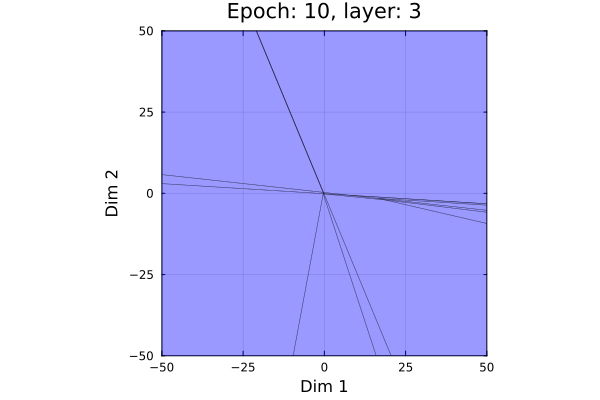

In [14]:
epoch = 10
layer = 3

# 1. Separate regions (using a bounding box for safety, or nothing for natural volume)
full_regs, empty_regs = separate_full_empty_regions(trees[epoch], layer)

# 2. Verify an "empty" region (just to be sure)
if !isempty(empty_regs)
    println("\nChecking first empty region volume: ", 
            get_region_volume(empty_regs[1], bound=100.0))
end

# # 3. Plot a "Full" region
# if !isempty(full_regs)
#     plot_single_region(full_regs[7], title="Full Region", bound=2.1)
# end
plt = plot_all_regions(full_regs, bound=50, title="Epoch: $epoch, layer: $layer")
display(plt)

In [15]:
for (i, r) in enumerate(empty_regs) # Print first 5
    # Natural volume (Inf if unbounded)
    vol_nat = get_region_volume(r)
    
    # Clipped volume (volume within box [-5, 5])
    vol_clip = get_region_volume(r, bound=50.0)
    
    println("Region $i | Unbounded: $(vol_nat == Inf) | Natural Vol: $vol_nat | Clipped Vol: $vol_clip")
end

Region 1 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 2 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 3 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 4 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 5 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 6 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 7 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 8 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 9 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 10 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 11 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 12 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 13 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 14 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Region 15 | Unbounded: false | Natural Vol: 0.0 | Clipped Vol: 0.0
Regi

In [16]:
for i in eachindex(trees)
    print_tree_summary(trees[i])
end


🌲 Geometric Tree Summary
• Input Dimension      : 2
• Depth (Layers)       : 4

-----------------------------------------------------------------
 Layer |  Neurons  |  Regions  |  Growth (Avg Children) 
-----------------------------------------------------------------
    0  |  Input    |        1  |                -
    1  |  3        |        7  |            7.00x
    2  |  3        |       21  |            3.00x
    3  |  3        |       59  |            2.81x
    4  |  1        |       82  |            1.39x
-----------------------------------------------------------------
   TOTAL NODES   |  170


🌲 Geometric Tree Summary
• Input Dimension      : 2
• Depth (Layers)       : 4

-----------------------------------------------------------------
 Layer |  Neurons  |  Regions  |  Growth (Avg Children) 
-----------------------------------------------------------------
    0  |  Input    |        1  |                -
    1  |  3        |        7  |            7.00x
    2  |  3        

In [17]:
pruned_trees = Dict{Int, Any}()

for epoch in epochs
    pruned_trees[epoch] = prune_tree!(trees[epoch])
end


✂️  Pruning Tree (Method: volume)...

✅ Pruning Complete:
   - Visited: 124
   - Kept:    98
   - Pruned:  26 branches

✂️  Pruning Tree (Method: volume)...

✅ Pruning Complete:
   - Visited: 92
   - Kept:    64
   - Pruned:  28 branches

✂️  Pruning Tree (Method: volume)...

✅ Pruning Complete:
   - Visited: 100
   - Kept:    78
   - Pruned:  22 branches

✂️  Pruning Tree (Method: volume)...

✅ Pruning Complete:
   - Visited: 102
   - Kept:    82
   - Pruned:  20 branches

✂️  Pruning Tree (Method: volume)...

✅ Pruning Complete:
   - Visited: 110
   - Kept:    87
   - Pruned:  23 branches


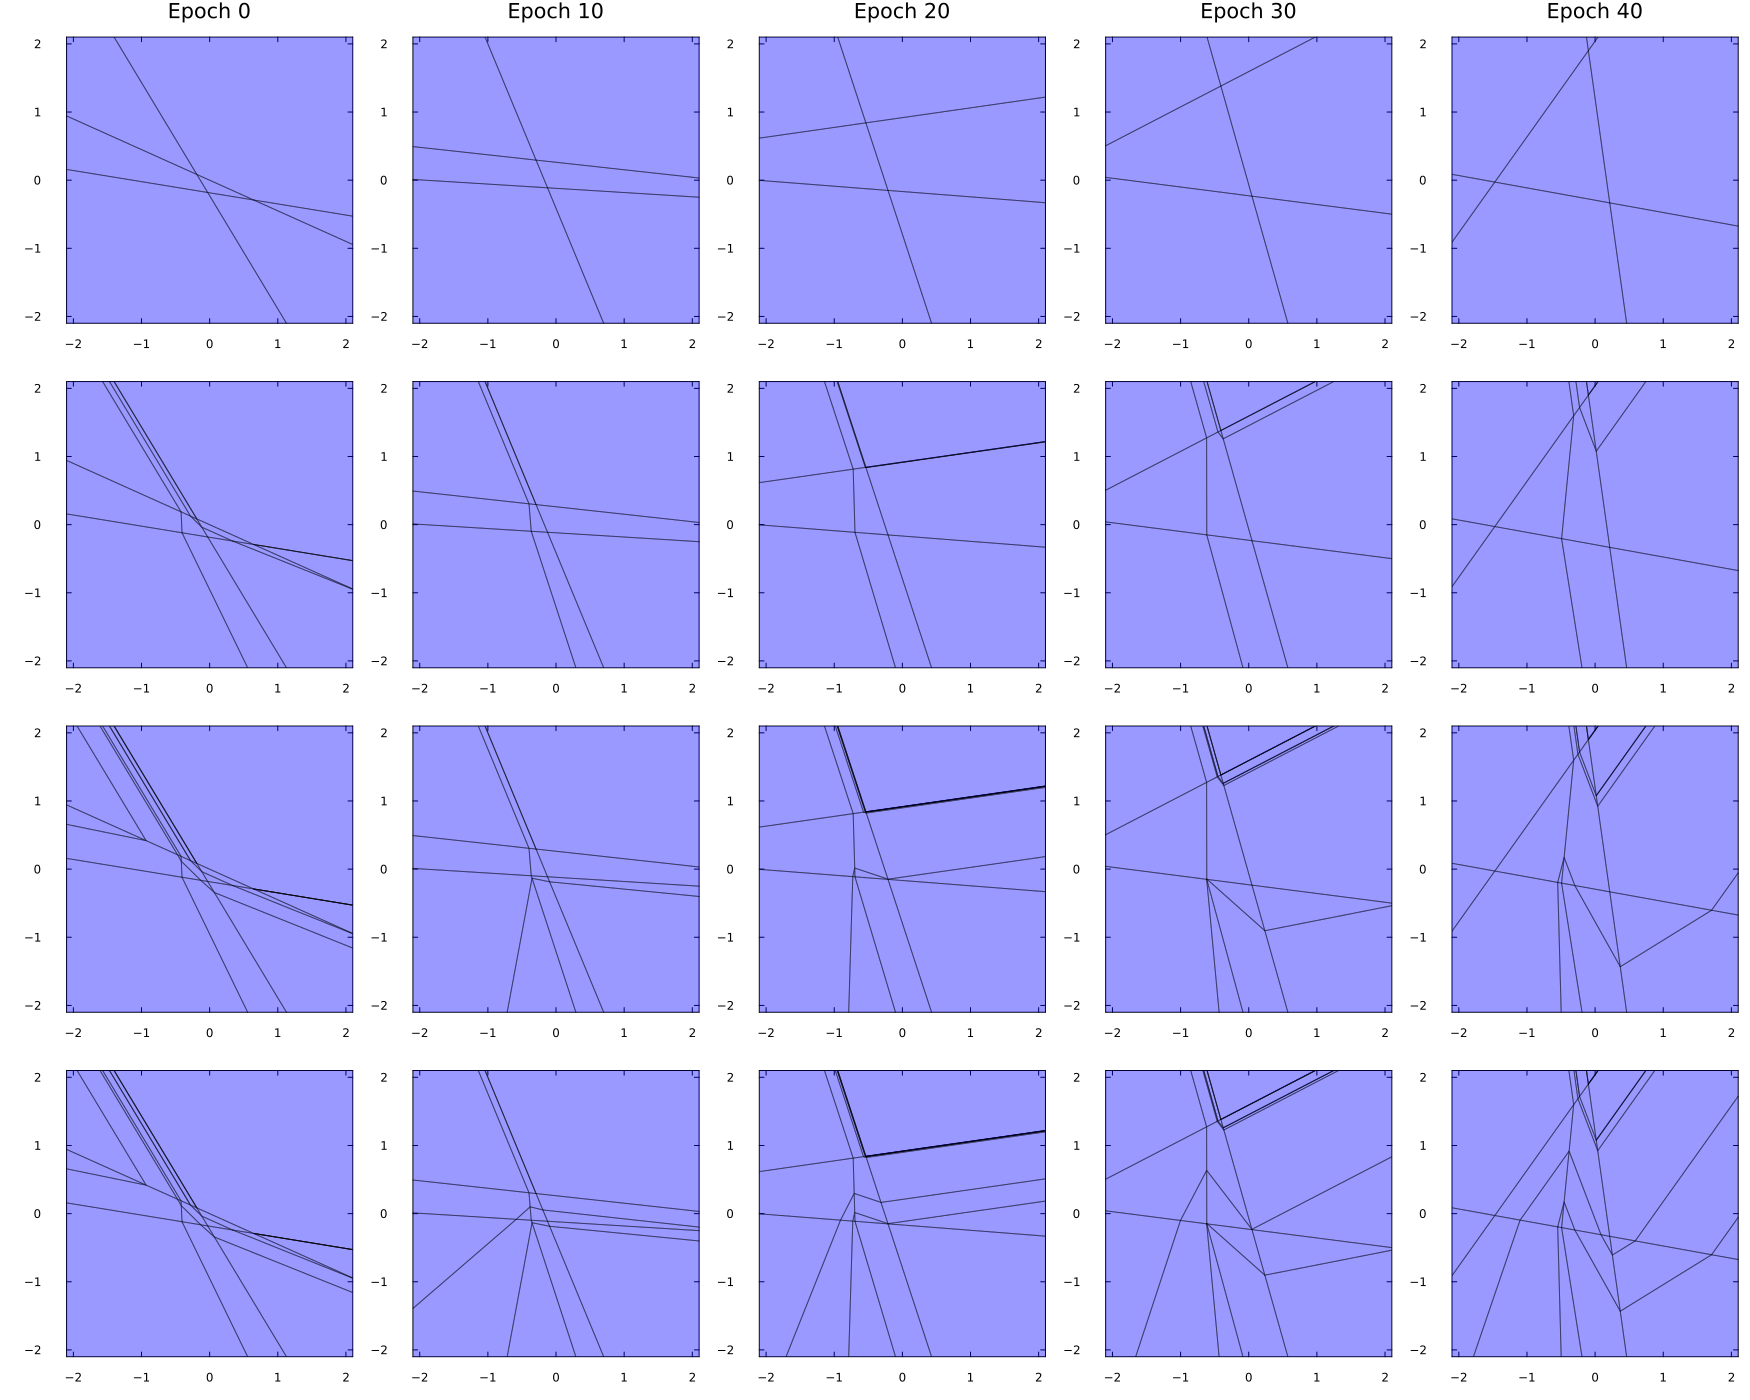

In [18]:
plt = plot_epoch_layer_grid(pruned_trees, bound=2.1)

In [20]:
for i in eachindex(pruned_trees)
    print_tree_summary(pruned_trees[i])
end


🌲 Geometric Tree Summary
• Input Dimension      : 2
• Depth (Layers)       : 4

-----------------------------------------------------------------
 Layer |  Neurons  |  Regions  |  Growth (Avg Children) 
-----------------------------------------------------------------
    0  |  Input    |        1  |                -
    1  |  3        |        7  |            7.00x
    2  |  3        |       19  |            2.71x
    3  |  3        |       35  |            1.84x
    4  |  1        |       37  |            1.06x
-----------------------------------------------------------------
   TOTAL NODES   |  99


🌲 Geometric Tree Summary
• Input Dimension      : 2
• Depth (Layers)       : 4

-----------------------------------------------------------------
 Layer |  Neurons  |  Regions  |  Growth (Avg Children) 
-----------------------------------------------------------------
    0  |  Input    |        1  |                -
    1  |  3        |        7  |            7.00x
    2  |  3        |